In [1]:
import gc
import os
import sys
import warnings
from glob import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
from segmentation_models_pytorch.decoders.unet.decoder import DecoderBlock
from timm.models.resnet import resnet10t, resnet34d
from torch.cuda import amp
from tqdm import tqdm
from einops import rearrange


In [2]:
sys.path.append('/kaggle/working/notebook/experiment/stacked_unet')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [3]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/24-39/"
    dataset_range = train_dataset_path.split("/")[-2]

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============

    z_start = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[0])
    z_end = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[1])
    in_chans = z_end-z_start+1
    
    crop_depth = 6
    random_shift = 2
    layer_shift = [0, 2, 4, 6, 8]
    
    # ============== training cfg =============
    size = 256
    tile_size = 256
    stride = tile_size //2

    train_batch_size = 64  # 32
    valid_batch_size = train_batch_size

    epochs = 30  # 15

    lr = 1e-4
    loss = "bce_dice_loss"


    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


### Load data

In [4]:
def preprocess(image, fragment_i, split_i):
    return image



len(train_images) = 11194
train_images[0].shape = (256, 256, 16)
train_labels[0].shape = (256, 256, 1)
train_masks[0].shape = (256, 256, 1)

len(valid_images) = 3087
valid_images[0].shape = (256, 256, 16)
valid_labels[0].shape = (256, 256, 1)



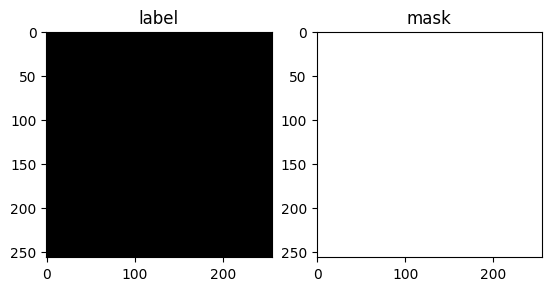

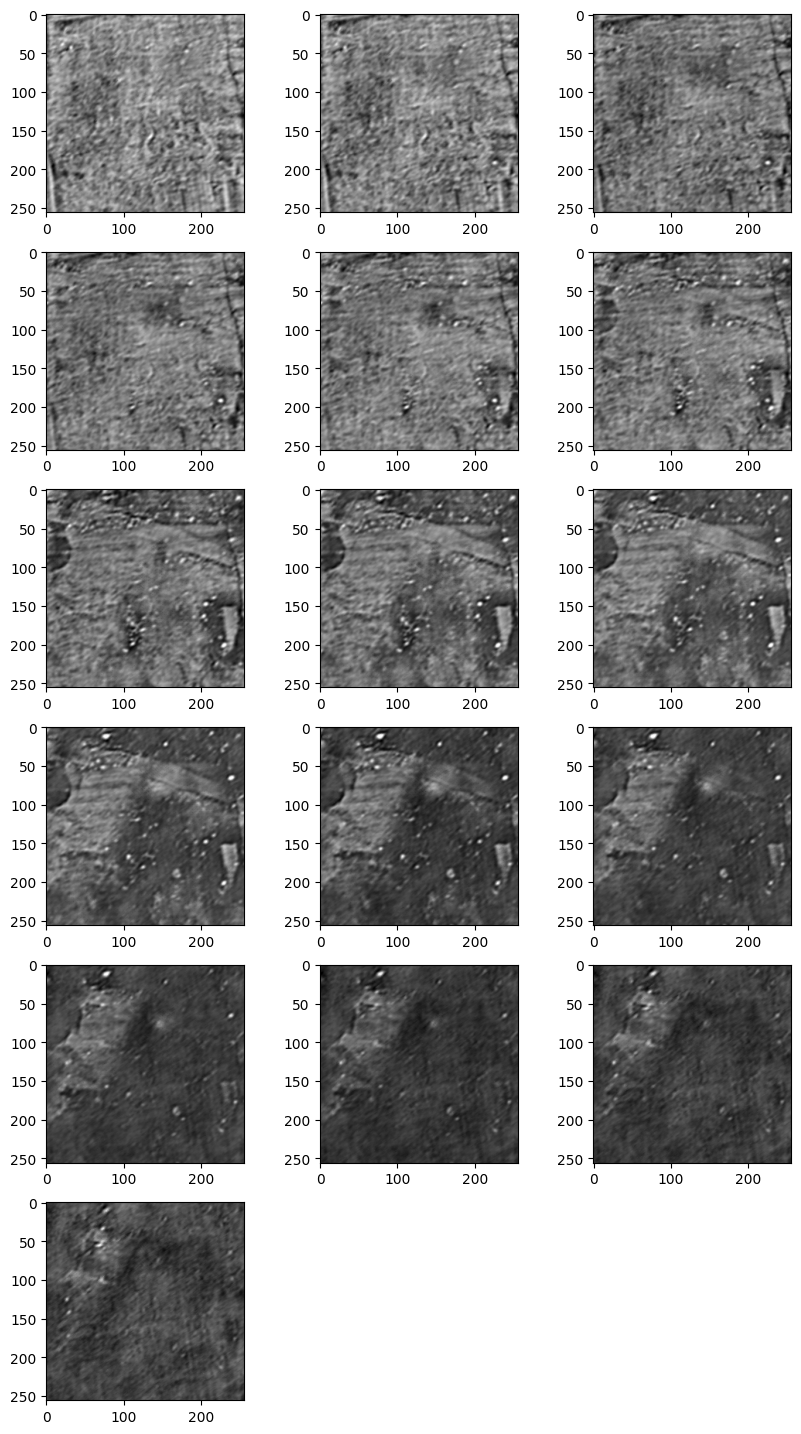

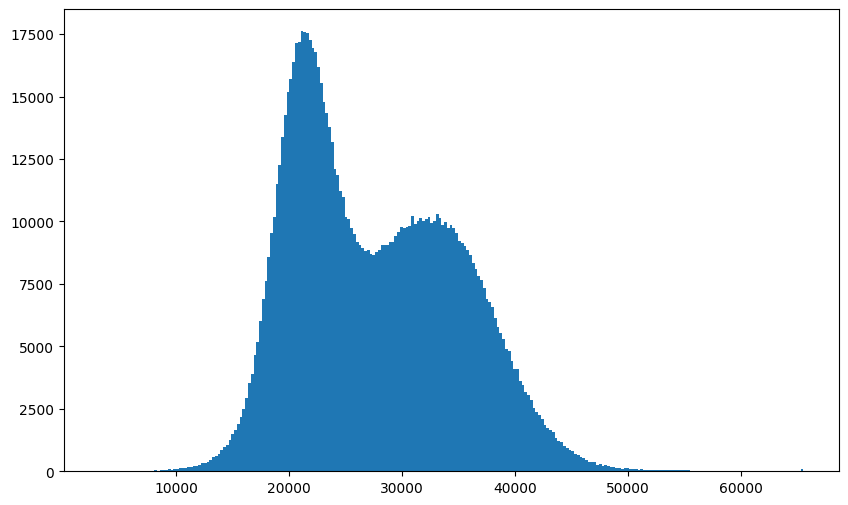

In [5]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


### Model

In [6]:
class SmpUnetDecoder(nn.Module):
    def __init__(self,
                 in_channel,
                 skip_channel,
                 out_channel,
                 ):
        super().__init__()
        self.center = nn.Identity()

        i_channel = [in_channel,] + out_channel[:-1]
        s_channel = skip_channel
        o_channel = out_channel
        block = [
            DecoderBlock(i, s, o, use_batchnorm=True, attention_type=None)
            for i, s, o in zip(i_channel, s_channel, o_channel)
        ]
        self.block = nn.ModuleList(block)

    def forward(self, feature, skip):
        d = self.center(feature)
        decode = []
        for i, block in enumerate(self.block):
            s = skip[i]
            d = block(d, s)
            decode.append(d)

        last = d
        return last, decode


class Net(nn.Module):
    def __init__(self,):
        super().__init__()
        self.output_type = ['inference', 'loss']

        conv_dim = 64
        encoder1_dim = [conv_dim, 64, 128, 256, 512, ]
        decoder1_dim = [256, 128, 64, 64,]

        self.encoder1 = resnet34d(pretrained=True, in_chans=CFG.crop_depth)

        self.decoder1 = SmpUnetDecoder(
            in_channel=encoder1_dim[-1],
            skip_channel=encoder1_dim[:-1][::-1],
            out_channel=decoder1_dim,
        )
        # -- pool attention weight
        self.weight1 = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            ) for dim in encoder1_dim
        ])
        self.logit1 = nn.Conv2d(decoder1_dim[-1], 1, kernel_size=1)

        # --------------------------------
        #
        encoder2_dim = [64, 128, 256, 512]
        decoder2_dim = [128, 64, 32, ]
        self.encoder2 = resnet10t(pretrained=True, in_chans=decoder1_dim[-1])

        self.decoder2 = SmpUnetDecoder(
            in_channel=encoder2_dim[-1],
            skip_channel=encoder2_dim[:-1][::-1],
            out_channel=decoder2_dim,
        )
        self.logit2 = nn.Conv2d(decoder2_dim[-1], 1, kernel_size=1)

    def forward(self, batch):
        v = batch
        B, C, H, W = v.shape
        random_shift = random.randint(0, CFG.random_shift)
        vv = [
            v[:, i+random_shift:i+random_shift+CFG.crop_depth] for i in CFG.layer_shift
        ]
        K = len(vv)
        x = torch.cat(vv, 0)
        # x = v

        # ----------------------
        encoder = []
        e = self.encoder1
        x = e.conv1(x)
        x = e.bn1(x)
        x = e.act1(x)
        encoder.append(x)
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        x = e.layer1(x)
        encoder.append(x)
        x = e.layer2(x)
        encoder.append(x)
        x = e.layer3(x)
        encoder.append(x)
        x = e.layer4(x)
        encoder.append(x)
        # print('encoder', [f.shape for f in encoder])

        for i in range(len(encoder)):
            e = encoder[i]
            e = F.avg_pool2d(e, kernel_size=4, stride=4)
            f = self.weight1[i](e)
            _, c, h, w = e.shape
            f = rearrange(f, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
            e = rearrange(e, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
            w = F.softmax(f, 1)
            e = (w * e).sum(1)
            encoder[i] = e

        feature = encoder[-1]
        skip = encoder[:-1][::-1]
        last, decoder = self.decoder1(feature, skip)
        logit1 = self.logit1(last)

        # ----------------------
        x = last  # .detach()
        # x = F.avg_pool2d(x,kernel_size=2,stride=2)
        encoder = []
        e = self.encoder2
        x = e.layer1(x)
        encoder.append(x)
        x = e.layer2(x)
        encoder.append(x)
        x = e.layer3(x)
        encoder.append(x)
        x = e.layer4(x)
        encoder.append(x)

        feature = encoder[-1]
        skip = encoder[:-1][::-1]
        last, decoder = self.decoder2(feature, skip)
        logit2 = self.logit2(last)
        logit1 = F.interpolate(logit1, size=(H, W), mode='bilinear', align_corners=False, antialias=True)
        logit2 = F.interpolate(logit2, size=(H, W), mode='bilinear', align_corners=False, antialias=True)

        return logit1, logit2


### Training

In [7]:
for fold_i, fold in enumerate(glob(f"{CFG.train_dataset_path}/*")):
    fold = os.path.basename(fold).split(".")[0]
    valid_fragment_i = int(fold.split("_")[0])
    valid_split_i = int(fold.split("_")[1])
    print(f"fold: {fold_i}")

    train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess, "inklabels")

    dataloader_train, dataloader_valid = generate_dataloader(train_images, train_labels,  valid_images, valid_labels, valid_xyxys, CFG)

    n_train = len(dataloader_train)
    n_valid = len(dataloader_valid)

    gt_mask = generate_valid_label(valid_fragment_i, valid_split_i, CFG, "inklabels")
    gt_shape = gt_mask.shape


    num_gpus = torch.cuda.device_count()
    device_ids = list(range(num_gpus))

    model = Net()
    model = nn.DataParallel(model, device_ids=device_ids)
    model = model.cuda()

    scaler = amp.GradScaler()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
    scheduler = get_scheduler(CFG, optimizer)

    fbeta = 0

    for epoch in range(CFG.epochs):
        model.train()
        cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        pbar_train = enumerate(dataloader_train)
        pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        mloss_train, mloss_val = 0.0, 0.0

        for i, (fragments, masks) in pbar_train:
            fragments, masks = fragments.cuda(), masks.cuda()
            optimizer.zero_grad()
            with amp.autocast():  # type: ignore
                logit1, logit2 = model(fragments)
                loss1 = criterion(logit1, masks)
                loss2 = criterion(logit2, masks)
                loss = loss1+loss2
                scaler.scale(loss).backward()# type: ignore
                scaler.step(optimizer)
                scaler.update()
                mloss_train += loss.detach().item()

            gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
            pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, cur_lr,
                                                                  f"Loss: {mloss_train / (i + 1):.4f}"))

        scheduler.step()
        model.eval()
        pbar_val = enumerate(dataloader_valid)
        pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')  # type: ignore
        final_pred_count = torch.zeros(gt_shape)

        for i, (fragments, masks, xys) in pbar_val:
            fragments, masks = fragments.cuda(), masks.cuda()
            with torch.no_grad():
                logit1, logit2 = model(fragments)
                loss1 = criterion(logit1, masks)
                loss2 = criterion(logit2, masks)
                loss = loss1+loss2
                mloss_val += loss.detach().item()
                pred_masks = torch.sigmoid(logit2)

            for j, xy in enumerate(xys):
                final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] += pred_masks[j, 0]
                final_pred_count[xy[1]:xy[3], xy[0]:xy[2]] += np.ones((CFG.size, CFG.size))

            pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
        final_pred_mask = final_pred_mask.cpu()
        final_pred_mask /= final_pred_count

        fbeta_ = fbeta_score(final_pred_mask, gt_mask, 0.5)
        print(f"FBeta : {fbeta_:.4f}\tSAVED MODEL\n" if fbeta_ > fbeta else f"FBeta : {fbeta_:.4f}\n")
        if fbeta_ > fbeta:
            fbeta = fbeta_
            model_path = f'./{CFG.exp_name}/{CFG.exp_name}_fold{fold_i}.pth'
            torch.save({'model': model.module.state_dict(),
                        'preds': final_pred_mask.numpy()},
                       model_path)

    del model
    gc.collect()
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify


fold: 0


Epoch 0/30  Mem : 21.8GB  LR : 1.00E-04  Loss: 0.9880: 100%|██████████| 174/174 
Val Loss: 0.7471: 100%|██████████| 49/49 [00:10<00:00,  4.58it/s]               


FBeta : 0.3442	SAVED MODEL



Epoch 1/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.6112: 100%|██████████| 174/174 
Val Loss: 0.5224: 100%|██████████| 49/49 [00:10<00:00,  4.82it/s]               


FBeta : 0.0000



Epoch 2/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4972: 100%|██████████| 174/174 
Val Loss: 0.5000: 100%|██████████| 49/49 [00:10<00:00,  4.77it/s]               


FBeta : 0.2332



Epoch 3/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4535: 100%|██████████| 174/174 
Val Loss: 0.5571: 100%|██████████| 49/49 [00:10<00:00,  4.78it/s]               


FBeta : 0.3903	SAVED MODEL



Epoch 4/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4364: 100%|██████████| 174/174 
Val Loss: 0.4503: 100%|██████████| 49/49 [00:10<00:00,  4.83it/s]               


FBeta : 0.5077	SAVED MODEL



Epoch 5/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4175: 100%|██████████| 174/174 
Val Loss: 0.8097: 100%|██████████| 49/49 [00:10<00:00,  4.80it/s]               


FBeta : 0.3635



Epoch 6/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4058: 100%|██████████| 174/174 
Val Loss: 0.5110: 100%|██████████| 49/49 [00:10<00:00,  4.78it/s]               


FBeta : 0.4840



Epoch 7/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3939: 100%|██████████| 174/174 
Val Loss: 0.4788: 100%|██████████| 49/49 [00:10<00:00,  4.81it/s]               


FBeta : 0.5040



Epoch 8/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3873: 100%|██████████| 174/174 
Val Loss: 0.4566: 100%|██████████| 49/49 [00:10<00:00,  4.81it/s]               


FBeta : 0.5303	SAVED MODEL



Epoch 9/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3785: 100%|██████████| 174/174 
Val Loss: 0.4539: 100%|██████████| 49/49 [00:10<00:00,  4.82it/s]               


FBeta : 0.5505	SAVED MODEL



Epoch 10/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3702: 100%|██████████| 174/174
Val Loss: 0.4597: 100%|██████████| 49/49 [00:10<00:00,  4.81it/s]               


FBeta : 0.5260



Epoch 11/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3595: 100%|██████████| 174/174
Val Loss: 0.4644: 100%|██████████| 49/49 [00:10<00:00,  4.74it/s]               


FBeta : 0.5051



Epoch 12/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3532: 100%|██████████| 174/174
Val Loss: 0.4965: 100%|██████████| 49/49 [00:10<00:00,  4.79it/s]               


FBeta : 0.4777



Epoch 13/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3491: 100%|██████████| 174/174
Val Loss: 0.4533: 100%|██████████| 49/49 [00:10<00:00,  4.78it/s]               


FBeta : 0.5513	SAVED MODEL



Epoch 14/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3397: 100%|██████████| 174/174
Val Loss: 0.5347: 100%|██████████| 49/49 [00:10<00:00,  4.79it/s]               


FBeta : 0.4724



Epoch 15/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3337: 100%|██████████| 174/174
Val Loss: 0.5275: 100%|██████████| 49/49 [00:10<00:00,  4.84it/s]               


FBeta : 0.4665



Epoch 16/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3246: 100%|██████████| 174/174
Val Loss: 0.4431: 100%|██████████| 49/49 [00:10<00:00,  4.79it/s]               


FBeta : 0.5614	SAVED MODEL



Epoch 17/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3214: 100%|██████████| 174/174
Val Loss: 0.4790: 100%|██████████| 49/49 [00:10<00:00,  4.77it/s]               


FBeta : 0.5135



Epoch 18/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3150: 100%|██████████| 174/174
Val Loss: 0.4669: 100%|██████████| 49/49 [00:10<00:00,  4.77it/s]               


FBeta : 0.5474



Epoch 19/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3081: 100%|██████████| 174/174
Val Loss: 0.5725: 100%|██████████| 49/49 [00:10<00:00,  4.82it/s]               


FBeta : 0.4584



Epoch 20/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2982: 100%|██████████| 174/174
Val Loss: 0.4750: 100%|██████████| 49/49 [00:10<00:00,  4.81it/s]               


FBeta : 0.5762	SAVED MODEL



Epoch 21/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2946: 100%|██████████| 174/174
Val Loss: 0.4510: 100%|██████████| 49/49 [00:10<00:00,  4.83it/s]               


FBeta : 0.5887	SAVED MODEL



Epoch 22/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2899: 100%|██████████| 174/174
Val Loss: 0.4368: 100%|██████████| 49/49 [00:10<00:00,  4.79it/s]               


FBeta : 0.5821



Epoch 23/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2839: 100%|██████████| 174/174
Val Loss: 0.4474: 100%|██████████| 49/49 [00:10<00:00,  4.76it/s]               


FBeta : 0.5626



Epoch 24/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2791: 100%|██████████| 174/174
Val Loss: 0.4483: 100%|██████████| 49/49 [00:10<00:00,  4.77it/s]               


FBeta : 0.5994	SAVED MODEL



Epoch 25/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2730: 100%|██████████| 174/174
Val Loss: 0.4559: 100%|██████████| 49/49 [00:10<00:00,  4.81it/s]               


FBeta : 0.6040	SAVED MODEL



Epoch 26/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2703: 100%|██████████| 174/174
Val Loss: 0.4985: 100%|██████████| 49/49 [00:10<00:00,  4.82it/s]               


FBeta : 0.5862



Epoch 27/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2682: 100%|██████████| 174/174
Val Loss: 0.4594: 100%|██████████| 49/49 [00:10<00:00,  4.78it/s]               


FBeta : 0.5736



Epoch 28/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2624: 100%|██████████| 174/174
Val Loss: 0.4602: 100%|██████████| 49/49 [00:10<00:00,  4.78it/s]               


FBeta : 0.5867



Epoch 29/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2614: 100%|██████████| 174/174
Val Loss: 0.4502: 100%|██████████| 49/49 [00:10<00:00,  4.83it/s]               


FBeta : 0.6042	SAVED MODEL

fold: 1


Epoch 0/30  Mem : 21.8GB  LR : 1.00E-04  Loss: 1.0642: 100%|██████████| 177/177 
Val Loss: 0.7152: 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]               


FBeta : 0.1062	SAVED MODEL



Epoch 1/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.6991: 100%|██████████| 177/177 
Val Loss: 0.3658: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.0198



Epoch 2/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.5595: 100%|██████████| 177/177 
Val Loss: 0.3276: 100%|██████████| 46/46 [00:10<00:00,  4.54it/s]               


FBeta : 0.4066	SAVED MODEL



Epoch 3/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.5123: 100%|██████████| 177/177 
Val Loss: 0.3174: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]               


FBeta : 0.4316	SAVED MODEL



Epoch 4/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4883: 100%|██████████| 177/177 
Val Loss: 0.2942: 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]               


FBeta : 0.4927	SAVED MODEL



Epoch 5/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4746: 100%|██████████| 177/177 
Val Loss: 0.2819: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.5255	SAVED MODEL



Epoch 6/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4561: 100%|██████████| 177/177 
Val Loss: 0.2763: 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]               


FBeta : 0.4605



Epoch 7/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4473: 100%|██████████| 177/177 
Val Loss: 0.2739: 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]               


FBeta : 0.4776



Epoch 8/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4300: 100%|██████████| 177/177 
Val Loss: 0.3575: 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]               


FBeta : 0.4093



Epoch 9/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4234: 100%|██████████| 177/177 
Val Loss: 0.2864: 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]               


FBeta : 0.3887



Epoch 10/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4171: 100%|██████████| 177/177
Val Loss: 0.2719: 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]               


FBeta : 0.5595	SAVED MODEL



Epoch 11/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4019: 100%|██████████| 177/177
Val Loss: 0.2575: 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]               


FBeta : 0.5606	SAVED MODEL



Epoch 12/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3963: 100%|██████████| 177/177
Val Loss: 0.2897: 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]               


FBeta : 0.5137



Epoch 13/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3893: 100%|██████████| 177/177
Val Loss: 0.4196: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]               


FBeta : 0.3997



Epoch 14/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3794: 100%|██████████| 177/177
Val Loss: 0.2840: 100%|██████████| 46/46 [00:10<00:00,  4.60it/s]               


FBeta : 0.5635	SAVED MODEL



Epoch 15/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3714: 100%|██████████| 177/177
Val Loss: 0.2681: 100%|██████████| 46/46 [00:10<00:00,  4.50it/s]               


FBeta : 0.5771	SAVED MODEL



Epoch 16/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3643: 100%|██████████| 177/177
Val Loss: 0.2894: 100%|██████████| 46/46 [00:10<00:00,  4.48it/s]               


FBeta : 0.5439



Epoch 17/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3583: 100%|██████████| 177/177
Val Loss: 0.2618: 100%|██████████| 46/46 [00:10<00:00,  4.60it/s]               


FBeta : 0.5684



Epoch 18/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3456: 100%|██████████| 177/177
Val Loss: 0.2943: 100%|██████████| 46/46 [00:10<00:00,  4.58it/s]               


FBeta : 0.5278



Epoch 19/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3403: 100%|██████████| 177/177
Val Loss: 0.2790: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.5974	SAVED MODEL



Epoch 20/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3352: 100%|██████████| 177/177
Val Loss: 0.2766: 100%|██████████| 46/46 [00:10<00:00,  4.58it/s]               


FBeta : 0.5634



Epoch 21/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3231: 100%|██████████| 177/177
Val Loss: 0.2797: 100%|██████████| 46/46 [00:10<00:00,  4.58it/s]               


FBeta : 0.5643



Epoch 22/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3169: 100%|██████████| 177/177
Val Loss: 0.2827: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]               


FBeta : 0.5821



Epoch 23/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3105: 100%|██████████| 177/177
Val Loss: 0.2686: 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]               


FBeta : 0.5948



Epoch 24/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3046: 100%|██████████| 177/177
Val Loss: 0.2662: 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]               


FBeta : 0.6039	SAVED MODEL



Epoch 25/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2969: 100%|██████████| 177/177
Val Loss: 0.2657: 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]               


FBeta : 0.6004



Epoch 26/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2917: 100%|██████████| 177/177
Val Loss: 0.2831: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.5833



Epoch 27/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2879: 100%|██████████| 177/177
Val Loss: 0.2810: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.5989



Epoch 28/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2859: 100%|██████████| 177/177
Val Loss: 0.2765: 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]               


FBeta : 0.5966



Epoch 29/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2827: 100%|██████████| 177/177
Val Loss: 0.2786: 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]               


FBeta : 0.5966

fold: 2


Epoch 0/30  Mem : 21.8GB  LR : 1.00E-04  Loss: 1.0355: 100%|██████████| 177/177 
Val Loss: 0.9355: 100%|██████████| 46/46 [00:10<00:00,  4.57it/s]               


FBeta : 0.3950	SAVED MODEL



Epoch 1/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.5962: 100%|██████████| 177/177 
Val Loss: 0.7783: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.0783



Epoch 2/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4514: 100%|██████████| 177/177 
Val Loss: 0.6815: 100%|██████████| 46/46 [00:09<00:00,  4.62it/s]               


FBeta : 0.4830	SAVED MODEL



Epoch 3/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4176: 100%|██████████| 177/177 
Val Loss: 0.6390: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.5233	SAVED MODEL



Epoch 4/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3993: 100%|██████████| 177/177 
Val Loss: 0.7664: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.4276



Epoch 5/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3845: 100%|██████████| 177/177 
Val Loss: 0.6357: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]               


FBeta : 0.5275	SAVED MODEL



Epoch 6/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3724: 100%|██████████| 177/177 
Val Loss: 0.6783: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]               


FBeta : 0.4533



Epoch 7/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3641: 100%|██████████| 177/177 
Val Loss: 0.7053: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]               


FBeta : 0.5105



Epoch 8/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3567: 100%|██████████| 177/177 
Val Loss: 0.7590: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]               


FBeta : 0.1530



Epoch 9/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3457: 100%|██████████| 177/177 
Val Loss: 0.6090: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.5992	SAVED MODEL



Epoch 10/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3457: 100%|██████████| 177/177
Val Loss: 0.5671: 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]               


FBeta : 0.6240	SAVED MODEL



Epoch 11/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3372: 100%|██████████| 177/177
Val Loss: 0.6276: 100%|██████████| 46/46 [00:10<00:00,  4.58it/s]               


FBeta : 0.5505



Epoch 12/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3285: 100%|██████████| 177/177
Val Loss: 0.6370: 100%|██████████| 46/46 [00:09<00:00,  4.62it/s]               


FBeta : 0.5699



Epoch 13/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3191: 100%|██████████| 177/177
Val Loss: 0.5679: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]               


FBeta : 0.6303	SAVED MODEL



Epoch 14/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3155: 100%|██████████| 177/177
Val Loss: 0.5946: 100%|██████████| 46/46 [00:10<00:00,  4.54it/s]               


FBeta : 0.5973



Epoch 15/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3094: 100%|██████████| 177/177
Val Loss: 0.6421: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.6245



Epoch 16/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3015: 100%|██████████| 177/177
Val Loss: 0.6050: 100%|██████████| 46/46 [00:09<00:00,  4.62it/s]               


FBeta : 0.6442	SAVED MODEL



Epoch 17/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2947: 100%|██████████| 177/177
Val Loss: 0.6174: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.6344



Epoch 18/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2894: 100%|██████████| 177/177
Val Loss: 0.6559: 100%|██████████| 46/46 [00:09<00:00,  4.60it/s]               


FBeta : 0.5944



Epoch 19/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2854: 100%|██████████| 177/177
Val Loss: 0.5868: 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]               


FBeta : 0.6375



Epoch 20/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2815: 100%|██████████| 177/177
Val Loss: 0.6104: 100%|██████████| 46/46 [00:10<00:00,  4.59it/s]               


FBeta : 0.6447	SAVED MODEL



Epoch 21/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2708: 100%|██████████| 177/177
Val Loss: 0.6376: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.6440



Epoch 22/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2673: 100%|██████████| 177/177
Val Loss: 0.6768: 100%|██████████| 46/46 [00:10<00:00,  4.59it/s]               


FBeta : 0.6356



Epoch 23/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2644: 100%|██████████| 177/177
Val Loss: 0.6388: 100%|██████████| 46/46 [00:10<00:00,  4.60it/s]               


FBeta : 0.6015



Epoch 24/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2584: 100%|██████████| 177/177
Val Loss: 0.6375: 100%|██████████| 46/46 [00:09<00:00,  4.62it/s]               


FBeta : 0.6318



Epoch 25/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2537: 100%|██████████| 177/177
Val Loss: 0.6456: 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]               


FBeta : 0.6446



Epoch 26/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2492: 100%|██████████| 177/177
Val Loss: 0.6494: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.6402



Epoch 27/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2478: 100%|██████████| 177/177
Val Loss: 0.6266: 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]               


FBeta : 0.6524	SAVED MODEL



Epoch 28/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2432: 100%|██████████| 177/177
Val Loss: 0.6698: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]               


FBeta : 0.6355



Epoch 29/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2435: 100%|██████████| 177/177
Val Loss: 0.6493: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.6415

fold: 3


Epoch 0/30  Mem : 21.8GB  LR : 1.00E-04  Loss: 1.0529: 100%|██████████| 177/177 
Val Loss: 0.8935: 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]               


FBeta : 0.2041	SAVED MODEL



Epoch 1/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.6093: 100%|██████████| 177/177 
Val Loss: 0.7302: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]               


FBeta : 0.2114	SAVED MODEL



Epoch 2/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4648: 100%|██████████| 177/177 
Val Loss: 0.6275: 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]               


FBeta : 0.5029	SAVED MODEL



Epoch 3/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4285: 100%|██████████| 177/177 
Val Loss: 0.6165: 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]               


FBeta : 0.5338	SAVED MODEL



Epoch 4/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4049: 100%|██████████| 177/177 
Val Loss: 0.6050: 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]               


FBeta : 0.3794



Epoch 5/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3951: 100%|██████████| 177/177 
Val Loss: 0.6023: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.4611



Epoch 6/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3798: 100%|██████████| 177/177 
Val Loss: 0.6972: 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]               


FBeta : 0.4461



Epoch 7/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3656: 100%|██████████| 177/177 
Val Loss: 0.5691: 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]               


FBeta : 0.5089



Epoch 8/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3592: 100%|██████████| 177/177 
Val Loss: 0.5736: 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]               


FBeta : 0.5768	SAVED MODEL



Epoch 9/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3506: 100%|██████████| 177/177 
Val Loss: 0.6236: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]               


FBeta : 0.4771



Epoch 10/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3412: 100%|██████████| 177/177
Val Loss: 0.5519: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.6232	SAVED MODEL



Epoch 11/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3367: 100%|██████████| 177/177
Val Loss: 0.5714: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]               


FBeta : 0.6129



Epoch 12/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3289: 100%|██████████| 177/177
Val Loss: 0.5589: 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]               


FBeta : 0.6361	SAVED MODEL



Epoch 13/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3224: 100%|██████████| 177/177
Val Loss: 0.5153: 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]               


FBeta : 0.6663	SAVED MODEL



Epoch 14/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3101: 100%|██████████| 177/177
Val Loss: 0.5795: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.6296



Epoch 15/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3034: 100%|██████████| 177/177
Val Loss: 0.5766: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.6138



Epoch 16/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3013: 100%|██████████| 177/177
Val Loss: 0.6455: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.5490



Epoch 17/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2948: 100%|██████████| 177/177
Val Loss: 0.5249: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.6643



Epoch 18/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2867: 100%|██████████| 177/177
Val Loss: 0.5161: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.6781	SAVED MODEL



Epoch 19/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2849: 100%|██████████| 177/177
Val Loss: 0.5369: 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]               


FBeta : 0.6697



Epoch 20/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2716: 100%|██████████| 177/177
Val Loss: 0.5599: 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]               


FBeta : 0.6605



Epoch 21/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2678: 100%|██████████| 177/177
Val Loss: 0.5531: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.6772



Epoch 22/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2673: 100%|██████████| 177/177
Val Loss: 0.5476: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]               


FBeta : 0.6785	SAVED MODEL



Epoch 23/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2589: 100%|██████████| 177/177
Val Loss: 0.5554: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.6732



Epoch 24/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2519: 100%|██████████| 177/177
Val Loss: 0.5359: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]               


FBeta : 0.6578



Epoch 25/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2494: 100%|██████████| 177/177
Val Loss: 0.5759: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.6233



Epoch 26/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2445: 100%|██████████| 177/177
Val Loss: 0.5566: 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]               


FBeta : 0.6853	SAVED MODEL



Epoch 27/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2465: 100%|██████████| 177/177
Val Loss: 0.5573: 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]               


FBeta : 0.6889	SAVED MODEL



Epoch 28/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2424: 100%|██████████| 177/177
Val Loss: 0.5567: 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]               


FBeta : 0.6748



Epoch 29/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2381: 100%|██████████| 177/177
Val Loss: 0.5493: 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]               


FBeta : 0.6818

fold: 4


Epoch 0/30  Mem : 21.8GB  LR : 1.00E-04  Loss: 0.9279: 100%|██████████| 185/185 
Val Loss: 0.7200: 100%|██████████| 38/38 [00:08<00:00,  4.57it/s]               


FBeta : 0.0392	SAVED MODEL



Epoch 1/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.5961: 100%|██████████| 185/185 
Val Loss: 0.4457: 100%|██████████| 38/38 [00:08<00:00,  4.67it/s]               


FBeta : 0.3561	SAVED MODEL



Epoch 2/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4993: 100%|██████████| 185/185 
Val Loss: 0.4057: 100%|██████████| 38/38 [00:08<00:00,  4.65it/s]               


FBeta : 0.4806	SAVED MODEL



Epoch 3/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4669: 100%|██████████| 185/185 
Val Loss: 0.3839: 100%|██████████| 38/38 [00:08<00:00,  4.61it/s]               


FBeta : 0.4300



Epoch 4/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4466: 100%|██████████| 185/185 
Val Loss: 0.3678: 100%|██████████| 38/38 [00:08<00:00,  4.61it/s]               


FBeta : 0.4852	SAVED MODEL



Epoch 5/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4305: 100%|██████████| 185/185 
Val Loss: 0.4561: 100%|██████████| 38/38 [00:08<00:00,  4.60it/s]               


FBeta : 0.0644



Epoch 6/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4186: 100%|██████████| 185/185 
Val Loss: 0.3719: 100%|██████████| 38/38 [00:08<00:00,  4.62it/s]               


FBeta : 0.4946	SAVED MODEL



Epoch 7/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.4053: 100%|██████████| 185/185 
Val Loss: 0.3745: 100%|██████████| 38/38 [00:08<00:00,  4.60it/s]               


FBeta : 0.5451	SAVED MODEL



Epoch 8/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3977: 100%|██████████| 185/185 
Val Loss: 0.3433: 100%|██████████| 38/38 [00:08<00:00,  4.63it/s]               


FBeta : 0.6088	SAVED MODEL



Epoch 9/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3859: 100%|██████████| 185/185 
Val Loss: 0.3345: 100%|██████████| 38/38 [00:08<00:00,  4.60it/s]               


FBeta : 0.6100	SAVED MODEL



Epoch 10/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3834: 100%|██████████| 185/185
Val Loss: 0.3540: 100%|██████████| 38/38 [00:08<00:00,  4.62it/s]               


FBeta : 0.5815



Epoch 11/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3725: 100%|██████████| 185/185
Val Loss: 0.3301: 100%|██████████| 38/38 [00:08<00:00,  4.69it/s]               


FBeta : 0.6072



Epoch 12/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3602: 100%|██████████| 185/185
Val Loss: 0.3489: 100%|██████████| 38/38 [00:08<00:00,  4.63it/s]               


FBeta : 0.5937



Epoch 13/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3587: 100%|██████████| 185/185
Val Loss: 0.4924: 100%|██████████| 38/38 [00:08<00:00,  4.62it/s]               


FBeta : 0.4684



Epoch 14/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3474: 100%|██████████| 185/185
Val Loss: 0.3567: 100%|██████████| 38/38 [00:08<00:00,  4.62it/s]               


FBeta : 0.5567



Epoch 15/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3379: 100%|██████████| 185/185
Val Loss: 0.3861: 100%|██████████| 38/38 [00:08<00:00,  4.60it/s]               


FBeta : 0.4698



Epoch 16/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3343: 100%|██████████| 185/185
Val Loss: 0.3384: 100%|██████████| 38/38 [00:08<00:00,  4.60it/s]               


FBeta : 0.6138	SAVED MODEL



Epoch 17/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3257: 100%|██████████| 185/185
Val Loss: 0.3407: 100%|██████████| 38/38 [00:08<00:00,  4.63it/s]               


FBeta : 0.5989



Epoch 18/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3173: 100%|██████████| 185/185
Val Loss: 0.3285: 100%|██████████| 38/38 [00:08<00:00,  4.61it/s]               


FBeta : 0.6340	SAVED MODEL



Epoch 19/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3075: 100%|██████████| 185/185
Val Loss: 0.3191: 100%|██████████| 38/38 [00:08<00:00,  4.63it/s]               


FBeta : 0.6534	SAVED MODEL



Epoch 20/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.3009: 100%|██████████| 185/185
Val Loss: 0.3326: 100%|██████████| 38/38 [00:08<00:00,  4.68it/s]               


FBeta : 0.6786	SAVED MODEL



Epoch 21/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2953: 100%|██████████| 185/185
Val Loss: 0.4576: 100%|██████████| 38/38 [00:08<00:00,  4.62it/s]               


FBeta : 0.4871



Epoch 22/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2885: 100%|██████████| 185/185
Val Loss: 0.3575: 100%|██████████| 38/38 [00:08<00:00,  4.64it/s]               


FBeta : 0.5904



Epoch 23/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2797: 100%|██████████| 185/185
Val Loss: 0.3624: 100%|██████████| 38/38 [00:08<00:00,  4.59it/s]               


FBeta : 0.5796



Epoch 24/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2804: 100%|██████████| 185/185
Val Loss: 0.4165: 100%|██████████| 38/38 [00:08<00:00,  4.61it/s]               


FBeta : 0.5097



Epoch 25/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2698: 100%|██████████| 185/185
Val Loss: 0.3593: 100%|██████████| 38/38 [00:08<00:00,  4.63it/s]               


FBeta : 0.5913



Epoch 26/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2687: 100%|██████████| 185/185
Val Loss: 0.3792: 100%|██████████| 38/38 [00:08<00:00,  4.65it/s]               


FBeta : 0.5534



Epoch 27/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2658: 100%|██████████| 185/185
Val Loss: 0.3335: 100%|██████████| 38/38 [00:08<00:00,  4.62it/s]               


FBeta : 0.6281



Epoch 28/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2633: 100%|██████████| 185/185
Val Loss: 0.3375: 100%|██████████| 38/38 [00:08<00:00,  4.58it/s]               


FBeta : 0.6267



Epoch 29/30  Mem : 21.8GB  LR : 1.00E-03  Loss: 0.2606: 100%|██████████| 185/185
Val Loss: 0.3437: 100%|██████████| 38/38 [00:08<00:00,  4.68it/s]               


FBeta : 0.6175

{"status":200,"message":"ok"}

In [8]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)

fbeta: 0.6042
fbeta: 0.6039
fbeta: 0.6524
fbeta: 0.6889
fbeta: 0.6786


In [9]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.6440


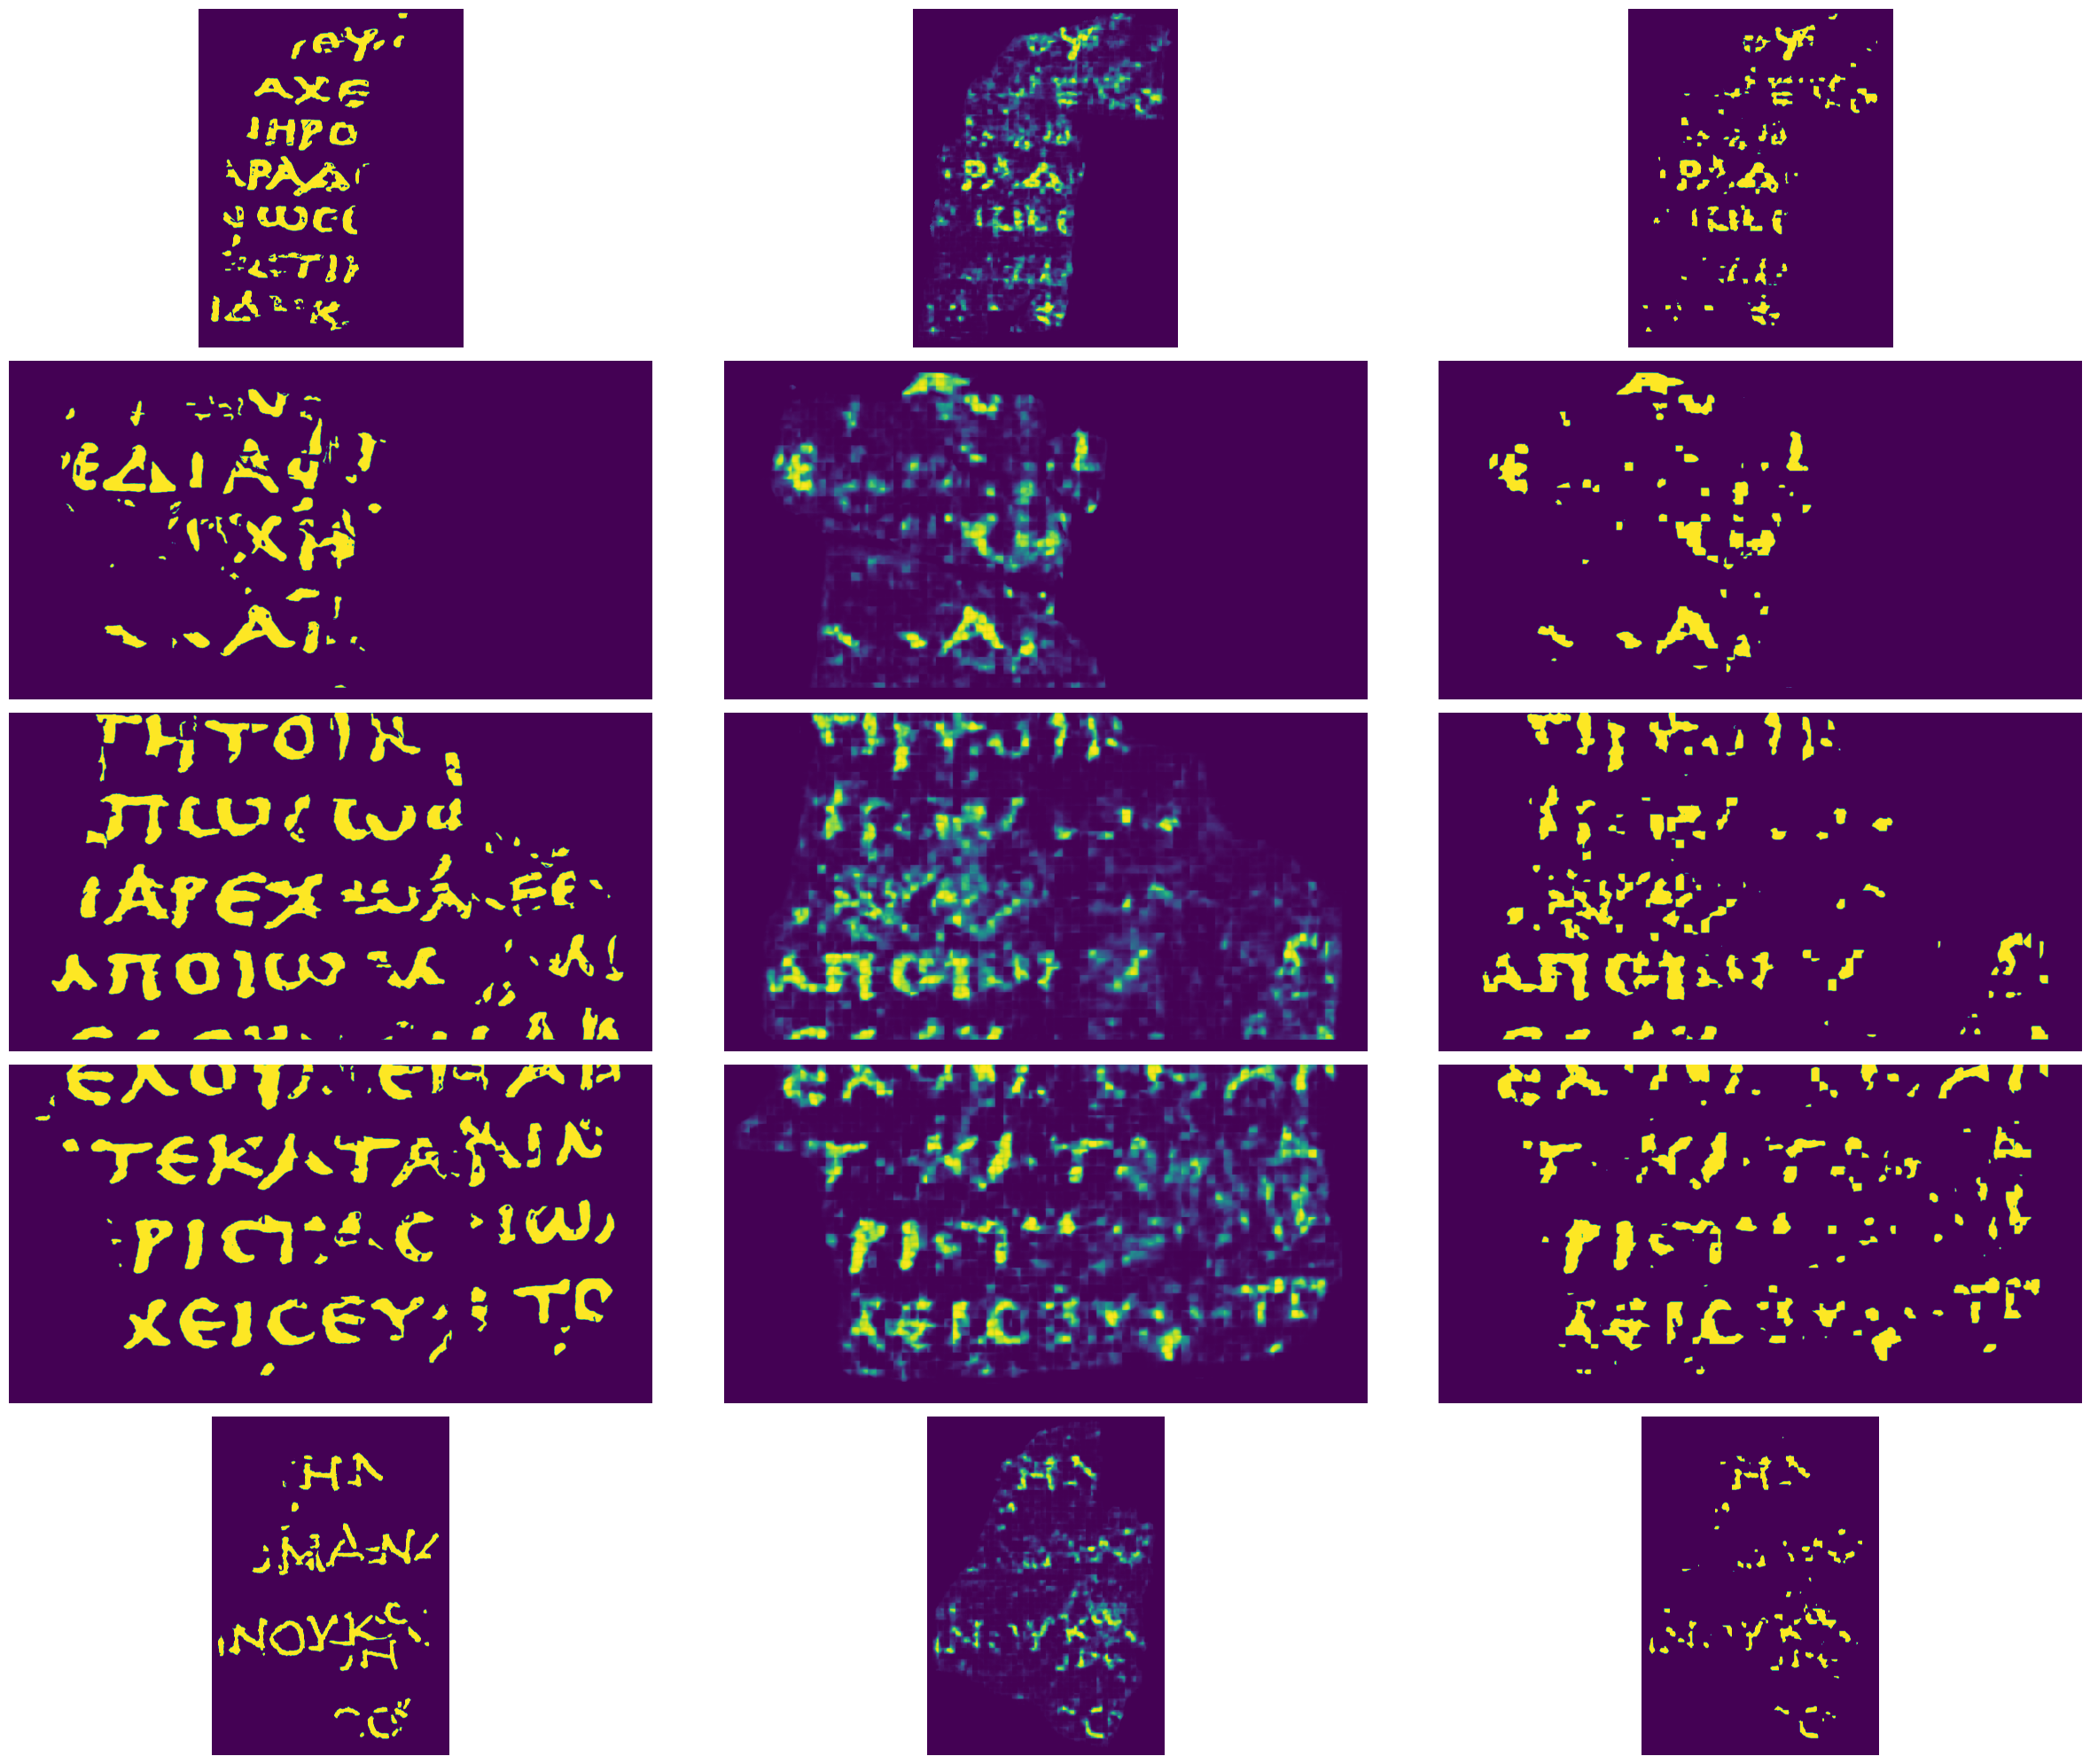

In [10]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)